In [27]:
import apriltag
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import binascii
import serial
import os

In [ ]:
# 连接网络
from pynq.lib import Wifi

port = Wifi()
ssid = "Luke's HUAWEI P30 Pro"
pwd  = "65712949"
port.connect(ssid, pwd)

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.


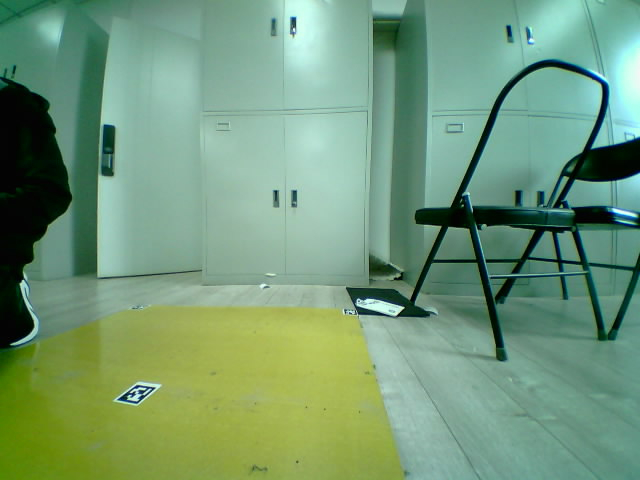

In [29]:
# 测试头部摄像头
orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
# !fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2> /dev/null
!fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2

img = Image.open(orig_img_path)
img

In [30]:
os.system('sh ./stop_sys_ttyPS0.sh')
def run_action(cmd):
    ser = serial.Serial("/dev/ttyPS0", 9600, timeout=5)
    cnt_err = 0
    while 1:
        test_read = ser.read()
        print('test_read', test_read)
        cnt_err += 1
        if test_read== b'\xa3' or cnt_err == 50:
            break
    
    if cnt_err == 50:
        print('can not get REQ')
    else:
        print('read REQ finished!')
        ser.write(cmd2data(cmd))
        print('send action ok!')
    ser.close()
def crc_calculate(package):
    crc = 0
    for hex_data in package:

        b2 = hex_data.to_bytes(1, byteorder='little')
        crc = binascii.crc_hqx(b2, crc)

    return [(crc >> 8), (crc & 255)]    # 校验位两位
def cmd2data(cmd):
    cnt=0
    cmd_list=[]
    for i in cmd:
        cnt+=1
        cmd_list+=[ord(i)]
    cmd_list=[0xff,0xff]+[(cnt+5)>>8,(cnt+5)&255]+[0x01,(cnt+1)&255,0x03]+cmd_list
    cmd_list=cmd_list+crc_calculate(cmd_list)
    return cmd_list
def wait_req():
    ser = serial.Serial("/dev/ttyPS0", 9600, timeout=5)
    while 1:
        test_read=ser.read()
        if test_read== b'\xa3' :
            print('read REQ finished!') 
            break

In [31]:
# 测试运动动作
run_action('XiaDun')
wait_req()
run_action('Stand')

test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!


In [111]:
# 更新img图像的函数
def updateImage():
    orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
    ! fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2
    img = Image.open(orig_img_path)
    return img


--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.


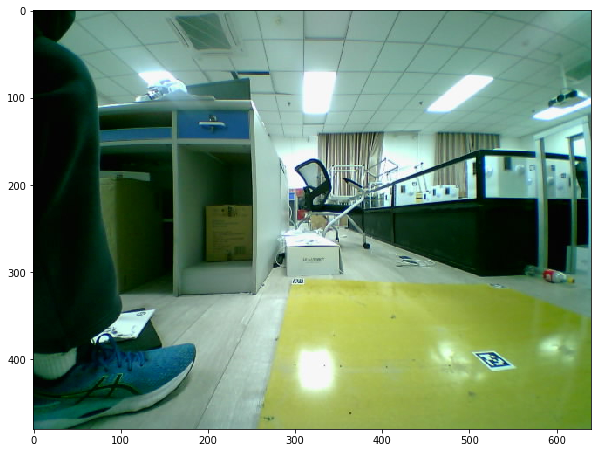

In [112]:
img = updateImage()
plt.figure(figsize=(10,10))
plt.imshow(img)
img = np.array(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [113]:
# 实例化检测器并检测Apriltag
options = apriltag.DetectorOptions(families='tag36h11',)
detector = apriltag.Detector(options)
tags = detector.detect(gray)
print(tags)

[Detection(tag_family=b'tag36h11', tag_id=3, hamming=0, goodness=0.0, decision_margin=71.02337646484375, homography=array([[  8.71328037e-01,   1.46980512e+00,   3.17197113e+01],
       [  6.41432095e-01,   5.59248787e-01,   2.40924424e+01],
       [  2.76921393e-03,   1.54883390e-03,   6.01995251e-02]]), center=array([ 526.90966066,  400.20984208]), corners=array([[ 525.73016357,  409.64846802],
       [ 506.69622803,  393.59594727],
       [ 527.93127441,  392.03463745],
       [ 547.95959473,  407.09744263]]))]


In [114]:
# 确定tag_position坐标
def load_tagpos():
    r1 = 5.00
    rx = 94.3
    ry = 94.5
    center = np.array([48.4, 47.7, 0])
    tag_positions = {}
    sftx = np.array([rx, 0, 0])
    sfty = np.array([0, ry, 0])
    tag_positions['1'] = np.array([
        [0, 0, 0],
        [r1, 0, 0],
        [r1, r1, 0],
        [0, r1, 0],
    ])
    tag_positions['2'] = tag_positions['1'] + sftx
    tag_positions['0'] = tag_positions['1'] + sfty
    tag_positions['5'] = tag_positions['2'] + sfty
    tag_positions['3'] = tag_positions['1'] + center

    destination = np.array([r1 / 2, r1 / 2 , 0]) + center
    return tag_positions, destination
tag_positions, destination = load_tagpos()

In [115]:
# 获取pos和corners的代码
tag_num = len(tags)
for n, tag in enumerate(tags):
    # 使用tag.id访问坐标，tag_positions的定义见前面，pos的形状为[4, 3]，分别代表已知的四个顶角在空间中的x,y,z三个坐标分量
    pos = tag_positions[str(tag.tag_id)]
    print(pos)
    # 四个顶角在图片中的像素位置(形状为[4, 2]，分别代表四个顶角的像素空间坐标) 
    corners = np.array(tag.corners)
    print(corners)
    # 之后请根据pos, corners或者**其他信息**来实现定位算法;
    # 提示:选手在实验中可以重复拍照定位， 也可以控制机器人转头拍照来获得更好的拍摄角度。
    # 另外，定位结果是摄像头的位置，请思考摄像头坐标与机器人坐标之间的关系。

[[ 48.4  47.7   0. ]
 [ 53.4  47.7   0. ]
 [ 53.4  52.7   0. ]
 [ 48.4  52.7   0. ]]
[[ 525.73016357  409.64846802]
 [ 506.69622803  393.59594727]
 [ 527.93127441  392.03463745]
 [ 547.95959473  407.09744263]]


In [116]:
def cameraPosition(pos,corners):
    '''
    根据输入(pos,corners)计算R,T旋转矩阵,并进一步完成机器人定位,计算机器人所在的(x,y,z)世界坐标
    input:
    pos,pos的形状为[4, 3],分别代表已知的四个顶角在空间中的x,y,z三个坐标分量
    corners,四个顶角在图片中的像素位置(形状为[4, 2]，分别代表四个顶角的像素空间坐标)
    output:cameraPosition = (x,y,z)机器人相机所在的世界坐标系
    '''
    # 2D坐标
    ImgPoints = corners
    # 3D坐标
    WorldPoints = pos
    # 内参矩阵
    fx = 202.0305
    fy = 203.5994
    cx = 312.0673
    cy = 237.1477
    intrinsic_matrix =  np.array([[fx,0,cx],
                              [0,fy,cy],
                              [0,0,1]],dtype = np.float64)
    # 畸变系数
    distCoeffs = np.array([0.1383,-0.0641,0,0])
    # 求解R和T的值
    retval, R, T = cv2.solvePnP(WorldPoints,ImgPoints,intrinsic_matrix,distCoeffs)
    rotM = cv2.Rodrigues(R)[0]
    cameraPosition = -np.matrix(rotM).T * np.matrix(T)
    
    return cameraPosition

In [117]:
# test cameraPostion(pos,corners)
print("pos = ",pos)
print("corners = ",corners)
C = cameraPosition(pos,corners)
print(C)

pos =  [[ 48.4  47.7   0. ]
 [ 53.4  47.7   0. ]
 [ 53.4  52.7   0. ]
 [ 48.4  52.7   0. ]]
corners =  [[ 525.73016357  409.64846802]
 [ 506.69622803  393.59594727]
 [ 527.93127441  392.03463745]
 [ 547.95959473  407.09744263]]
[[ 19.45475597]
 [ 20.7208864 ]
 [-74.1164984 ]]


In [99]:
def moveL(left,forward):
    # 先走left步,再走forward步
    for i in range(left):
        run_action('Left3move')
        wait_req()
    run_action('turn003L')
    wait_req()
    for i in range(forward):
        run_action('Forwalk02')
        wait_req()
        run_action('turn003L')
        wait_req()
    

def moveR(right,forward):
    # 先走forward步,再走right步
    for i in range(right):
        run_action('Right3move')
        wait_req()
    for i in range(forward):
        run_action('Forwalk02')
        wait_req()
        run_action('turn003L')
        wait_req()
    

In [101]:
# 测试moveL()/moveR()函数
moveR(8,5)

test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
t

read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'


In [83]:

run_action('Left3move')

test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!


In [141]:
# 总的决策函数,最终运行此函数即可
def decision():

    # 获取头部摄像头拍摄图片
    img = updateImage()
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 实例化检测器并检测Apriltag
    options = apriltag.DetectorOptions(families='tag36h11',)
    detector = apriltag.Detector(options)
    tags = detector.detect(gray)

    # 打印出来tags信息,便于具体调试
    print(tags)

    # 加载世界坐标系坐标
    tag_positions, destination = load_tagpos()

    # 获取pos和corners,即像素坐标
    tag_num = len(tags)
    for n, tag in enumerate(tags):
        # 使用tag.id访问坐标，tag_positions的定义见前面，pos的形状为[4, 3]，分别代表已知的四个顶角在空间中的x,y,z三个坐标分量
        pos = tag_positions[str(tag.tag_id)]
        print(pos)
        # 四个顶角在图片中的像素位置(形状为[4, 2]，分别代表四个顶角的像素空间坐标) 
        corners = np.array(tag.corners)
        print(corners)
    
    # 根据pos, corners实现的定位算法:
    
    # 调用cameraPostion(pos,corners)得到机器人所在位置的世界坐标系坐标
    C = cameraPosition(pos,corners)
    print(C)

    # TODO:实测阈值与范围确定
    X,Y = C[0],C[1]
    print()

    # TODO:随便取的常数示例,需要线下实测
    if X > 65  and Y > 65:
        moveL(12,3)
    elif X > 80 and Y < 40:
        moveL(9,4)
    elif X < 40 and Y > 10 :
        moveR(8,5)
    
    print("success!")
    

In [ ]:
decision()

--- Opening /dev/video0...
Trying source module v4l2...
/dev/video0 opened.
No input was specified, using the first.
Adjusting resolution from 384x288 to 640x480.
--- Capturing frame...
Captured frame in 0.00 seconds.
--- Processing captured image...
Disabling banner.
Writing JPEG image to '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'.
Writing JPEG image to '2'.
[Detection(tag_family=b'tag36h11', tag_id=3, hamming=2, goodness=0.0, decision_margin=68.19305419921875, homography=array([[  1.24884424e+00,   1.30165713e+00,   3.14313522e+01],
       [  9.62059296e-01,   4.33689877e-01,   2.44951720e+01],
       [  3.54103081e-03,   1.25696576e-03,   6.06193146e-02]]), center=array([ 518.50391929,  404.0819699 ]), corners=array([[ 517.38031006,  413.81005859],
       [ 498.83709717,  397.80917358],
       [ 519.46270752,  395.78088379],
       [ 539.71081543,  410.84597778]]))]
[[ 48.4  47.7   0. ]
 [ 53.4  47.7   0. ]
 [ 53.4  52.7   0. ]
 [ 48.4  52.7   0. ]]
[[ 517.38031006  413

test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0e'
test_read b'\x06'
test_read b'E'
test_read b'R'
test_read b'R'
test_read b'O'
test_read b'R'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b' '
test_read b'\x13'
test_read b'\xff'
test_read b'\xff'
test_read b'\x00'
test_read b'\x0c'
test_read b'\x04'
test_read b'R'
test_read b'E'
test_read b'Q'
test_read b'\x00'
test_read b'\x01'
test_read b'\x03'
test_read b'\x02'
test_read b'\x00'
test_read b'\x00'
test_read b'\x8e'
test_read b'\xa3'
read REQ finished!
send action ok!
read REQ finished!
test_read b'\xff'
test_read 